In [2]:
%load_ext autoreload
%autoreload 2

# Predicting Titanic Survival Using Machine Learning

In this notebook, I will be using Python machine learning and data science libraries such as Scikit-learn, to try building a machine learning model capable of predicting the survival of someone on the RMS Titanic. 

This is a Machine Learning challenge/competition from Kaggle: https://www.kaggle.com/competitions/titanic/overview

```
"The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others."
```

We're going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem Definition

> Given some information (name, age, gender, socio-economic class) of an individual aboard the RMS Titanic, can we predict whether or not they survived the shipwreck?

## 2. Data

The data for this analysis was obtained from the Kaggle Titanic competition: 

https://www.kaggle.com/competitions/titanic/overview

This dataset is widely believed to be a subset of the "Titanic Passenger Survival Data" originally compiled by Thomas Cason and hosted by the Department of Biostatistics at Vanderbilt University.

It is important to note that while the data is based on the historical record from Encyclopedia Titanica, it is not an exhaustive list of everyone on board. Specifically, this dataset contains 1,309 records (split into train/test sets) and focuses exclusively on passengers, notably excluding the ~900 crew members who were also aboard the ship.

## 3. Evaluation

> If we can reach 80% accuracy at predicting whether or not a passenger can survive the shipwreck, I'll submit it to Kaggle haha. Realistically, this would mean successful proof of concept, which can then be refined even futher for real world use.

## 4. Features

| Variable | Role | Type | Description | Units / Key | Missing Values |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **survival** | Target | Integer | Survival status | 0 = No, 1 = Yes | No |
| **pclass** | Feature | Integer | Ticket class (Proxy for SES) | 1 = 1st, 2 = 2nd, 3 = 3rd | No |
| **sex** | Feature | Object | Sex | male, female | No |
| **Age** | Feature | Float | Age in years | Years | **Yes** |
| **sibsp** | Feature | Integer | # of siblings / spouses aboard | Count | No |
| **parch** | Feature | Integer | # of parents / children aboard | Count | No |
| **ticket** | Feature | Object | Ticket number | Alphanumeric | No |
| **fare** | Feature | Float | Passenger fare | Currency | No |
| **cabin** | Feature | Object | Cabin number | Alphanumeric | **Yes** |
| **embarked** | Feature | Object | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton | **Yes** |

* **survival**: This is the target variable that indicates whether the passenger survived (1) or died (0).
* **pclass**: This represents the ticket class (1st, 2nd, or 3rd) and acts as a proxy for socio-economic status.
* **sex**: This records the gender of the passenger.
* **Age**: This is the passenger's age in years, which may be fractional for infants.
* **sibsp**: This counts the total number of siblings and spouses traveling with the passenger.
* **parch**: This counts the total number of parents and children traveling with the passenger.
* **ticket**: This is the unique alphanumeric ticket number printed on the passenger's ticket.
* **fare**: This records the monetary price the passenger paid for their journey.
* **cabin**: This lists the specific cabin number assigned to the passenger, though many values are missing.
* **embarked**: This indicates the port where the passenger boarded the ship (Cherbourg, Queenstown, or Southampton).


### Tools

Pandas, matplotlib, numPy, and scikit-learn (AND XGBoost)

In [3]:
# regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# data manipulation pipeline (imputing, encoding)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer

# models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# XGBoost
from xgboost import XGBClassifier

# model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

### Load Data

In [4]:
df = pd.read_csv("data/titanic_train.csv")
df.shape

(891, 12)

## Data Exploration (exploratory data analysis)

Let's explore this dataset and think about the following:

```
1. What question(s) are we trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do we deal with it?
4. Where are the outliers and why should we care about them?
5. How can we add, change, or remove features to get more out of the data?
```



In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

We can see that in our dataset, 342 passengers survived and 549 did not, out of 891 total.

In [7]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    str    
 4   Sex          891 non-null    str    
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    str    
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    str    
 11  Embarked     889 non-null    str    
dtypes: float64(2), int64(5), str(5)
memory usage: 83.7 KB


In [8]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that there are many missing values for cabin, a decent amount of missing values for age, and 2 missing values for embarked.

In [9]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that the average age (non-missing) is 29.6 years. The average fare is 32. 

In [10]:
df.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [11]:
pd.crosstab(df.Survived, df.Sex)

Sex,female,male
Survived,,
0,81,468
1,233,109


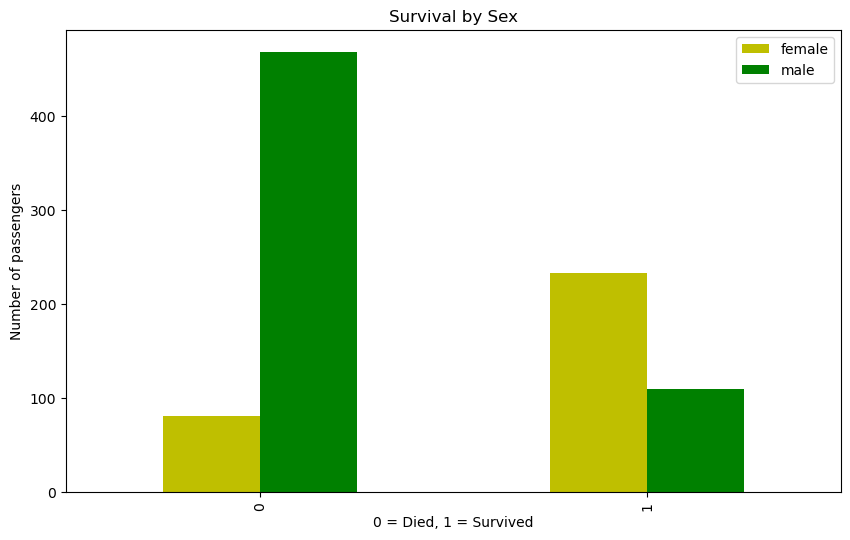

In [12]:
pd.crosstab(df.Survived, df.Sex).plot(kind="bar", figsize=(10,6), color=["y", "g"])

plt.title("Survival by Sex")
plt.xlabel("0 = Died, 1 = Survived")
plt.ylabel("Number of passengers")
plt.legend()

In [13]:
df.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

#### Basic Heuristic

From just this feature, we can see that sex likely played a big role in survival. 74% of females survived, and 18% of males. 

What about socio-economic-status? That may indicate something. 

In [14]:
pd.crosstab(df.Survived, df.Pclass)

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


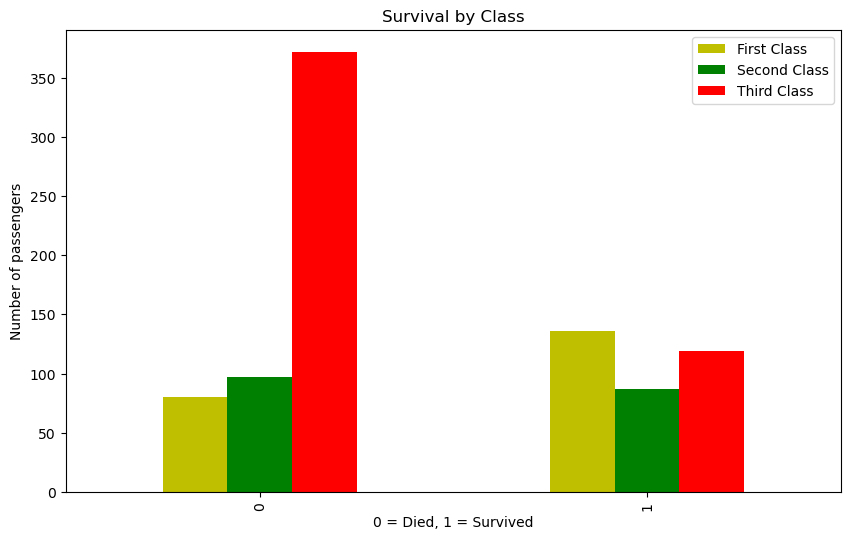

In [15]:
pd.crosstab(df.Survived, df.Pclass).plot(kind="bar", figsize=(10,6), color=["y", "g", "r"])

plt.title("Survival by Class")
plt.xlabel("0 = Died, 1 = Survived")
plt.ylabel("Number of passengers")
plt.legend(["First Class", "Second Class", "Third Class"])

#### Another heuristic

SES likely has some predictive value on survival as well.

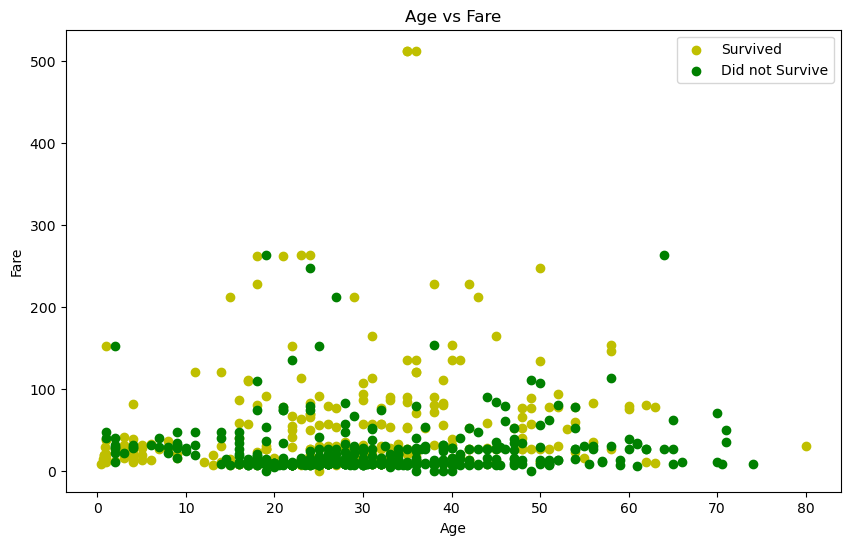

In [16]:
# create another figure
plt.figure(figsize=(10,6))

# scatter with positive examples
plt.scatter(df.Age[df.Survived==1],df.Fare[df.Survived==1],c="y")

# scatter with negative examples
plt.scatter(df.Age[df.Survived==0],df.Fare[df.Survived==0],c="g")

plt.title("Age vs Fare")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.legend(["Survived", "Did not Survive"])

<Axes: ylabel='Frequency'>

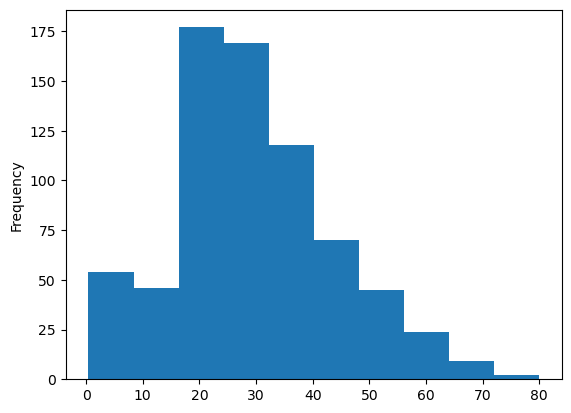

In [17]:
df.Age.plot.hist()

<Axes: ylabel='Frequency'>

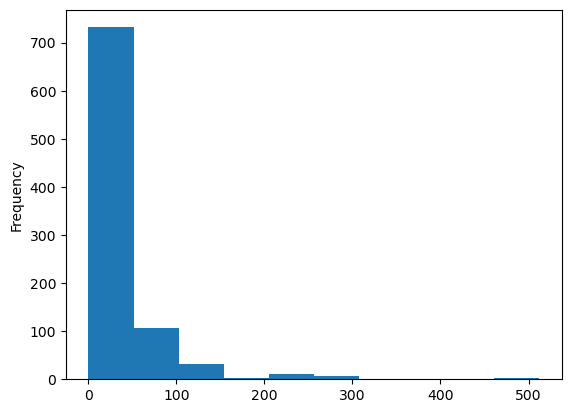

In [18]:
df.Fare.plot.hist()

## 5. Modelling

Here we will:

- Massage the Data
- Try some different models & hyperparameter tuning
- Evaluate the models

In [19]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    str    
 4   Sex          891 non-null    str    
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    str    
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    str    
 11  Embarked     889 non-null    str    
dtypes: float64(2), int64(5), str(5)
memory usage: 83.7 KB


### Massage the Data

Let's massage the data so that it is ready for ML models to train on. 

We need to:

```
1. Deal with categorical data (turn strings into numbers - and potentially one-hot encode them)
2. Deal with missing data (fill in with dummy data, or remove data will missing labels)
3. Decide how to use enumerations data (such as ticket#, potentially create new features)
```


In [20]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [21]:
np.random.seed(12)

X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
from src.preprocessing import sex_transformer
from src.preprocessing import age_transformer
from src.preprocessing import embarked_transformer

clean_features = ["Pclass", "Fare", "SibSp", "Parch"]

preprocessor = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        ("embarked", embarked_transformer(), ["Embarked"]),
        ("age", age_transformer(), ["Age"]),

        # pass through columns
        ("clean_cols", "passthrough", clean_features)
    ], 
remainder="drop")

pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", RandomForestClassifier())])


In [23]:
# let's inspect what our transformation preprocessor does right now

X_train_transformed = preprocessor.fit_transform(X_train)

new_columns = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_transformed, columns=new_columns)

X_train_df.head()

,sex__Sex,embarked__Embarked_C,embarked__Embarked_Q,embarked__Embarked_S,age__Age,clean_cols__Pclass,clean_cols__Fare,clean_cols__SibSp,clean_cols__Parch
0,0.0,0.0,0.0,1.0,27.000000,3.0,11.1333,0.0,2.0
1,1.0,0.0,0.0,1.0,51.000000,2.0,12.5250,0.0,0.0
2,1.0,0.0,0.0,1.0,27.000000,2.0,13.0000,0.0,0.0
3,1.0,0.0,0.0,1.0,30.000000,3.0,7.2500,0.0,0.0
4,1.0,0.0,0.0,1.0,29.495193,3.0,69.5500,8.0,2.0


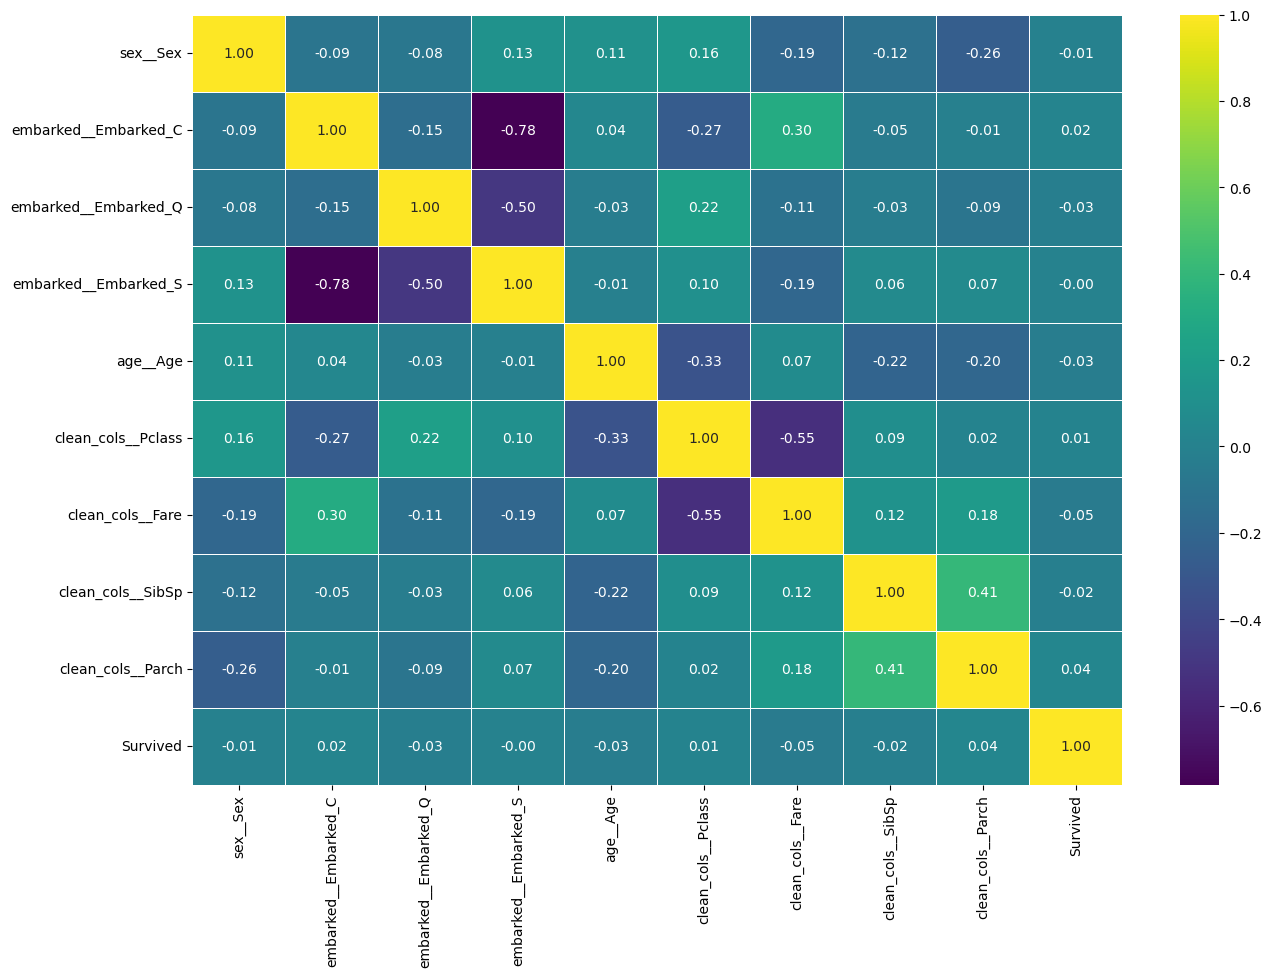

In [24]:
cleaned_df = X_train_df
cleaned_df["Survived"] = y
corr_matrix = cleaned_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="viridis")

### Train different models & search through hyperparameters

Models: 
```
- RandomForestClassifier()
- KNeighborsClassifier()
- LogisticRegression()
```


In [25]:
from src.evaluation import evaluate_preds
from src.evaluation import fit_and_score

In [26]:
# Let's start by checking the default performance of each model. 
models = {
    "Logistic Regression": Pipeline(steps=[
        ("preprocessor", preprocessor), 
        ("model", LogisticRegression(max_iter=1000))
    ]),
    
    "KNN": Pipeline(steps=[
        ("preprocessor", preprocessor), 
        ("model", KNeighborsClassifier())
    ]),
    
    "Random Forest": Pipeline(steps=[
        ("preprocessor", preprocessor), 
        ("model", RandomForestClassifier())
    ])
}


In [27]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

{'Logistic Regression': 0.7988826815642458,
 'KNN': 0.6424581005586593,
 'Random Forest': 0.770949720670391}

Notice how KNN seems to be scoring a bit low. Let's explore KNN a bit more to see if hyperparameters can fix it

In [28]:
# lets tune KNN (manual tuning)

train_scores = []
test_scores = []

# create a list of different values for n_neighbors
neighbors = range(1, 51)

# setup KNN instance
knn = Pipeline(steps=[
        ("preprocessor", preprocessor), 
        ("model", KNeighborsClassifier())
    ])

# loop through different n_neighbors
for i in neighbors:
    knn.set_params(model__n_neighbors=i)

    # fit the algorithm
    knn.fit(X_train, y_train)

    # update the training scores list
    train_scores.append(knn.score(X_train, y_train))

    # update the test scores list
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 69.83%


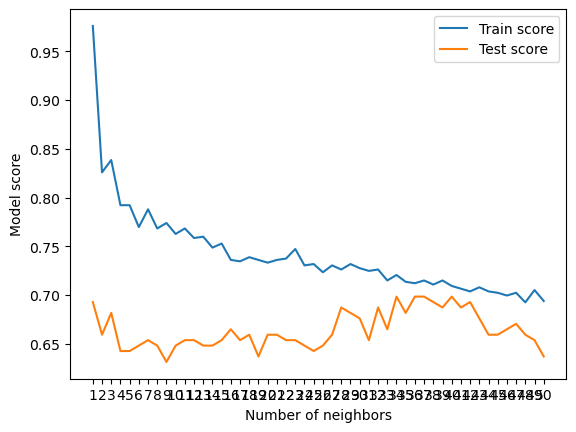

In [29]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1,51,1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

Based on these results, KNN may probably be excluded in our experimentation and hyperparameter tuning for now. 

In [30]:

param_grid = [
    # Option 1: Random Forest Classifier
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': list(range(10, 500, 10)),
        'model__max_depth': [None] + list(range(10, 50, 5)),
        'model__min_samples_split': [1, 2, 5, 10, 15, 20],
        'model__min_samples_leaf': [1, 2, 3, 4, 6, 8],
        'model__bootstrap': [True]
        
    },

    # Option 2: Logistic Regression
    {
        'model': [LogisticRegression()],
        'model__max_iter': [50, 100, 200, 500, 1000, 2000],
        'model__C': np.logspace(-4, 4, 20),
        'model__solver': ['liblinear', 'lbfgs', 'newton-cholesky'], 
        'model__l1_ratio': [0,1]
    }
]

In [31]:
rand_search = RandomizedSearchCV(pipeline, param_grid, cv=5, n_iter=200, n_jobs=-1, verbose=True)

# This will run preprocessing -> fit RF, then preprocessing -> fit LinearReg, etc.
rand_search.fit(X_train, y_train)

print("Best model:", rand_search.best_estimator_)
print("Best params:", rand_search.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/opt/miniconda3/envs/titanic-env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:490: FitFailedWarning: 
175 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/titanic-env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/titanic-env/lib/python3.13/site-packages/sklearn/base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/miniconda3/envs/titanic-env/lib/python3.13/si

Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sex',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('embarked',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='C',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked']),
                                                 ('age',
                      

In [32]:
rand_search_preds = rand_search.predict(X_test)

rand_search_metrics = evaluate_preds(y_test, rand_search_preds)

Acc: 76.54%
Precision: 0.80
Recall: 0.62
F1 score: 0.70


In [33]:
param_grid = [
    # Option 1: Random Forest Classifier
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [250, 300, 330, 360, 410],
        'model__max_depth': [10, 15, 25, 30, 35, 40],
        'model__min_samples_split': [1, 2, 3, 6, 12],
        'model__min_samples_leaf': [1, 2, 3],
        'model__bootstrap': [True]
        
    }
    #,

    # Option 2: Logistic Regression
    #{
    #    'model': [LogisticRegression()],
    #    'model__max_iter': [200, 500],
    #    'model__C': np.logspace(-2,1,10),
    #    'model__solver': ['liblinear', 'lbfgs', 'newton-cholesky'], 
    #    'model__l1_ratio': [0]
    #}
    
]

In [34]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=True)

# This will run preprocessing -> fit RF, then preprocessing -> fit LinearReg, etc.
grid_search.fit(X_train, y_train)

print("Best model:", grid_search.best_estimator_)
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sex',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('embarked',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='C',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked']),
               

/opt/miniconda3/envs/titanic-env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:490: FitFailedWarning: 
450 fits failed out of a total of 2250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/titanic-env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/titanic-env/lib/python3.13/site-packages/sklearn/base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/miniconda3/envs/titanic-env/lib/python3.13/si

In [35]:
grid_search.score(X_test, y_test)

0.7821229050279329

In [36]:
grid_search_preds = grid_search.predict(X_test)

grid_search_metrics = evaluate_preds(y_test, grid_search_preds)

Acc: 78.21%
Precision: 0.84
Recall: 0.62
F1 score: 0.72


In [37]:
grid_search.best_params_

{'model': RandomForestClassifier(),
 'model__bootstrap': True,
 'model__max_depth': 35,
 'model__min_samples_leaf': 3,
 'model__min_samples_split': 3,
 'model__n_estimators': 330}

It seems like our RandomForestClassifier is our best fitting model so far. 
What else can we do to improve our results further? 

- Try more models (gradient-boosted tree perhaps)
- Introduce more features (Name, Cabin, Ticket)
- Introduce derived features
- Remove unrelated features

### Let's do some more evaluating our tuned machine learning classifier, beyond accuracy

* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1 score


In [38]:
best_model = Pipeline(steps=[("preprocessor",preprocessor),
                             ("model",RandomForestClassifier(max_depth=30, 
                                                             min_samples_leaf=1, 
                                                             min_samples_split=12, 
                                                             n_estimators=410, 
                                                             bootstrap=True))])
best_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('sex', ...), ('embarked', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different trans

In [39]:
y_preds = best_model.predict(X_test)
y_preds_proba = best_model.predict_proba(X_test)
y_scores = y_preds_proba[:,1]

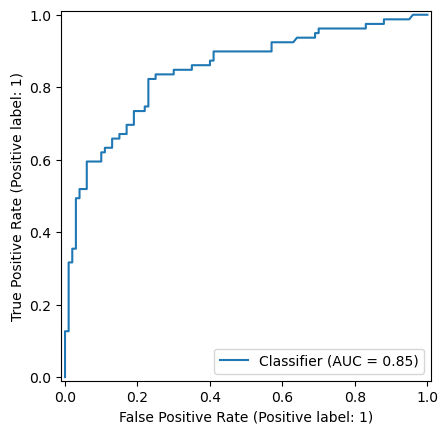

In [40]:
RocCurveDisplay.from_predictions(y_true=y_test, y_score=y_scores)

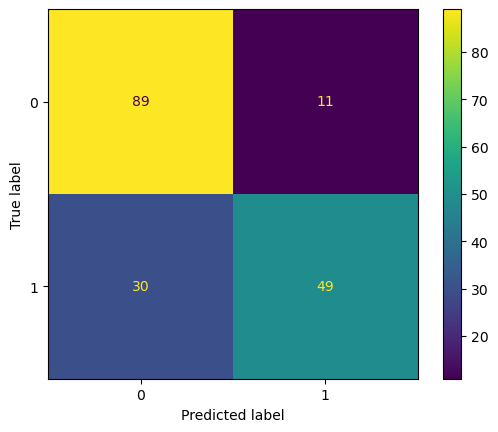

In [41]:
ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_preds)

In [42]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       100
           1       0.82      0.62      0.71        79

    accuracy                           0.77       179
   macro avg       0.78      0.76      0.76       179
weighted avg       0.78      0.77      0.77       179



In [43]:
from src.evaluation import cross_validated_scores

In [44]:
cv_scores_rf = cross_validated_scores(best_model, X, y, 5)
cv_scores_rf

{'accuracy': np.float64(0.8305567760969179),
 'precision': np.float64(0.8276249345571568),
 'recall': np.float64(0.7103580562659847),
 'f1': np.float64(0.7573859302536758)}

### Can we identify important features?

                Feature  Importance
0              sex__Sex    0.378038
6      clean_cols__Fare    0.211267
4              age__Age    0.164578
5    clean_cols__Pclass    0.124401
7     clean_cols__SibSp    0.042362
8     clean_cols__Parch    0.034594
3  embarked__Embarked_S    0.020876
1  embarked__Embarked_C    0.013441
2  embarked__Embarked_Q    0.010444


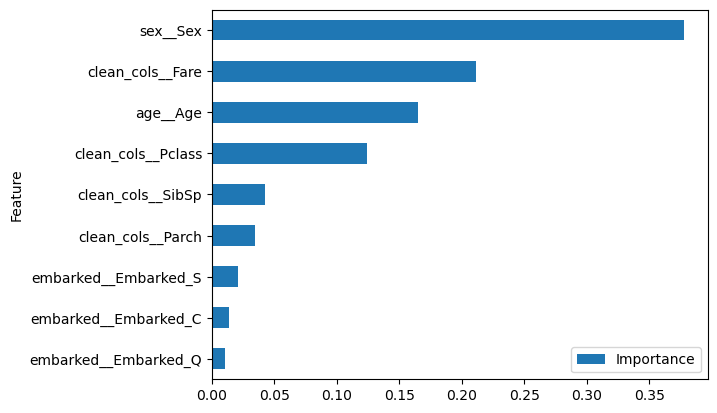

In [45]:
# 1. Access the specific step in your pipeline named "model"
rf_model = best_model.named_steps["model"]

# 2. Get the feature importances (array of numbers)
importances = rf_model.feature_importances_

# 3. Get the feature names from the preprocessor
# (Crucial because OneHotEncoder generated new columns like "Sex_male")
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

# 4. Create a DataFrame to view them clearly
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# 5. Sort by importance so the most useful features are at the top
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# View the top 10
print(importance_df)

# Plot
importance_df.plot.barh(x="Feature", y="Importance")
plt.gca().invert_yaxis() # Flip so top feature is at the top
plt.show()

### The following: include Cabin & Ticket prefixes into the data, check for feature importance (experiment)

In [46]:
from src.preprocessing import cabin_transformer
from src.preprocessing import ticket_transformer

clean_features = ["Pclass", "Fare", "SibSp", "Parch"]

preprocessor2 = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        ("embarked", embarked_transformer(), ["Embarked"]),
        ("age", age_transformer(), ["Age"]),

        # new features
        ("cabin", cabin_transformer(), ["Cabin"]),
        ("ticket", ticket_transformer(), ["Ticket"]),
        # pass through columns
        ("clean_cols", "passthrough", clean_features)
    ], 
remainder="drop")

pipeline2 = Pipeline(steps=[("preprocessor", preprocessor2),
                           ("model", RandomForestClassifier())])

In [47]:
models = {
    "Logistic Regression": Pipeline(steps=[
        ("preprocessor", preprocessor2), 
        ("model", LogisticRegression(max_iter=1000))
    ]),
    
    "KNN": Pipeline(steps=[
        ("preprocessor", preprocessor2), 
        ("model", KNeighborsClassifier())
    ]),
    
    "Random Forest": Pipeline(steps=[
        ("preprocessor", preprocessor2), 
        ("model", RandomForestClassifier())
    ])
}

model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

{'Logistic Regression': 0.776536312849162,
 'KNN': 0.6424581005586593,
 'Random Forest': 0.7932960893854749}

In [48]:
grid_search = GridSearchCV(pipeline2, param_grid, cv=5, n_jobs=-1, verbose=True)

# This will run preprocessing -> fit RF, then preprocessing -> fit LinearReg, etc.
grid_search.fit(X_train, y_train)

print("Best model:", grid_search.best_estimator_)
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sex',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('embarked',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='C',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked']),
               

/opt/miniconda3/envs/titanic-env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:490: FitFailedWarning: 
450 fits failed out of a total of 2250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/titanic-env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/titanic-env/lib/python3.13/site-packages/sklearn/base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/miniconda3/envs/titanic-env/lib/python3.13/si

In [49]:
best_model = Pipeline(steps=[("preprocessor",preprocessor2),
                             ("model",RandomForestClassifier(max_depth=25, 
                                                             min_samples_leaf=2, 
                                                             min_samples_split=12, 
                                                             n_estimators=300, 
                                                             bootstrap=True))])
best_model.fit(X_train, y_train)

best_model.score(X_test, y_test)

0.770949720670391

In [50]:
cv_scores = cross_validated_scores(best_model, X, y, 5)
cv_scores

{'accuracy': np.float64(0.8170924612390935),
 'precision': np.float64(0.8078797256607562),
 'recall': np.float64(0.6986786018755329),
 'f1': np.float64(0.7449467804351325)}

                              Feature  Importance
0                            sex__Sex    0.348609
21                   clean_cols__Fare    0.170031
4                            age__Age    0.116062
20                 clean_cols__Pclass    0.102411
12                     cabin__Cabin_M    0.057887
23                  clean_cols__Parch    0.036742
22                  clean_cols__SibSp    0.034359
3                embarked__Embarked_S    0.018810
1                embarked__Embarked_C    0.014526
19  ticket__Ticket_infrequent_sklearn    0.011733
9                      cabin__Cabin_E    0.011375
2                embarked__Embarked_Q    0.010845
8                      cabin__Cabin_D    0.010763
6                      cabin__Cabin_B    0.010760
16             ticket__Ticket_Numeric    0.010721
18              ticket__Ticket_STON/O    0.008950
17                  ticket__Ticket_PC    0.008691
7                      cabin__Cabin_C    0.005865
15                ticket__Ticket_C.A.    0.003788


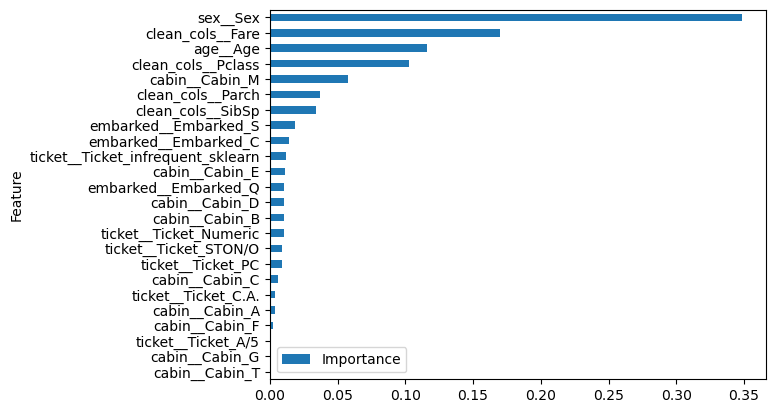

In [51]:
# 1. Access the specific step in your pipeline named "model"
rf_model = best_model.named_steps["model"]

# 2. Get the feature importances (array of numbers)
importances = rf_model.feature_importances_

# 3. Get the feature names from the preprocessor
# (Crucial because OneHotEncoder generated new columns like "Sex_male")
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

# 4. Create a DataFrame to view them clearly
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# 5. Sort by importance so the most useful features are at the top
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# View the top 10
print(importance_df)

# Plot
importance_df.plot.barh(x="Feature", y="Importance")
plt.gca().invert_yaxis() # Flip so top feature is at the top
plt.show()

### Now, let's try some more ideas: 

- Using gradient-boosted trees instead of RandomForestClassifier
- Feature engineering: specifically:
    - Grouping Age into categories (bins)
    - Grouping Fare into categories (bins)
    - Grouping individuals into families
    - Extracting information from passenger names (specifically their title, Mr. Mrs. Miss. Rev. etc)


In [52]:
xgbmodel = Pipeline(steps=[("preprocessor",preprocessor),
                             ("model",XGBClassifier())])

xgbmodel.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('sex', ...), ('embarked', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different trans

In [53]:
xgbmodel.score(X_test, y_test)

0.7486033519553073

In [54]:
param_grid_xgb = [
    {
        'model': [XGBClassifier()],
        'model__n_estimators': [100, 200, 300, 400, 500, 800],
        'model__learning_rate': [0.02, 0.1,0.2, 0.3, 0.5, 0.6],
        'model__max_depth': [0, 3, 5, 8, 10, 17],
        'model__subsample': [0.6, 0.8, 1],
        'model__min_child_weight': [1, 2]
    }
]

In [55]:
rand_search = RandomizedSearchCV(xgbmodel, param_grid_xgb, cv=5, n_iter=800, n_jobs=-1, verbose=True)

# This will run preprocessing -> fit RF, then preprocessing -> fit LinearReg, etc.
rand_search.fit(X_train, y_train)

print("Best model:", rand_search.best_estimator_)
print("Best params:", rand_search.best_params_)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sex',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('embarked',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='C',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked']),
               

In [56]:
rand_search.score(X_test, y_test)

0.770949720670391

In [57]:
rand_search.score(X_train, y_train)

0.8876404494382022

In [58]:
param_grid_xgb = [
    {
        'model': [XGBClassifier()],
        'model__n_estimators': [250, 280, 310, 340, 360, 400],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.06, 0.1],
        'model__max_depth': [3, 4, 5, 6, 7, 8],
        'model__subsample': [0.8, 1],
        'model__min_child_weight': [1, 2, 3]
    }
]

In [59]:
grid_search = GridSearchCV(xgbmodel, param_grid_xgb, cv=5, n_jobs=-1, verbose=True)

# This will run preprocessing -> fit RF, then preprocessing -> fit LinearReg, etc.
grid_search.fit(X_train, y_train)

print("Best model:", grid_search.best_estimator_)
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sex',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('embarked',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='C',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked']),
              

In [60]:
grid_search.score(X_test, y_test)

0.7653631284916201

In [61]:
grid_search.score(X_train, y_train)

0.8890449438202247

Based on these results, it's possible that the XGB classifier is better than the RandomForestClassifier here. Let's get some more metrics

In [62]:
xgb_model = Pipeline(steps=[("preprocessor",preprocessor),
                             ("model",XGBClassifier(max_depth=3, 
                                                             subsample=1,
                                                            min_child_weight=3,
                                                    learning_rate=0.04,
                                                             n_estimators=350))])
xgb_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('sex', ...), ('embarked', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different trans

In [63]:
y_preds = xgb_model.predict(X_test)
y_preds_proba = xgb_model.predict_proba(X_test)
y_scores = y_preds_proba[:,1]

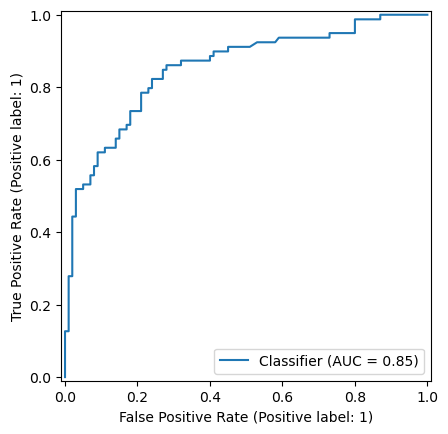

In [64]:
RocCurveDisplay.from_predictions(y_true=y_test, y_score=y_scores)

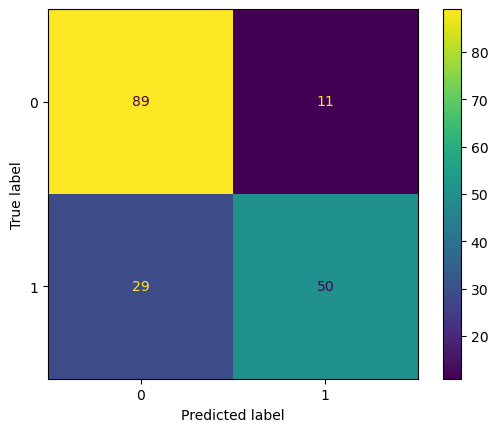

In [65]:
ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_preds)

In [66]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.75      0.89      0.82       100
           1       0.82      0.63      0.71        79

    accuracy                           0.78       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.78      0.78      0.77       179



In [67]:
cv_scores_xgb = cross_validated_scores(xgb_model, X, y, 5)
cv_scores_xgb

{'accuracy': np.float64(0.8305567760969179),
 'precision': np.float64(0.824329763803448),
 'recall': np.float64(0.7104859335038363),
 'f1': np.float64(0.7628536550989189)}

In [68]:
cv_scores_rf

{'accuracy': np.float64(0.8305567760969179),
 'precision': np.float64(0.8276249345571568),
 'recall': np.float64(0.7103580562659847),
 'f1': np.float64(0.7573859302536758)}

XGBoost here seems to have slighly better scores

### Feature engineering: lets experiment

- Feature engineering: specifically:
    - Grouping Age into categories (bins)
    - Grouping Fare into categories (bins)
    - Grouping individuals into families
    - Extracting information from passenger names (specifically their title, Mr. Mrs. Miss. Rev. etc)

In [69]:
print(df[['Age', 'Fare']].describe())

              Age        Fare
count  714.000000  891.000000
mean    29.699118   32.204208
std     14.526497   49.693429
min      0.420000    0.000000
25%     20.125000    7.910400
50%     28.000000   14.454200
75%     38.000000   31.000000
max     80.000000  512.329200


Let's group fare into quartiles, to try to mitigate the outlier somewhat. 
- 1st Quartile (0-7.91)
- 2nd Quartile (7.91-14.45)
- 3rd Quartile (14.45-31)
- 4th Quartile (31+)

I'll also try to bin age into the following:

- Infant (0-3)
- Small child (3-6)
- Medium child (6-10)
- Large child (10-14)
- Adolescent (14-20)
- Young adult (20-25)
- Adult (25-30)
- Old adult (30-40)
- Older adult (40-55)
- Senior (55+)

### Important Correction:

Since we are using XGBoost, this "binning" process no longer applies. XGBoost actually handles the binning better than manually binning, and it can also handle "missing" values which we were previously imputing (ex. the age). So we will be doing passthrough instead. 

In [70]:
clean_features = ["Pclass", "Fare", "SibSp", "Parch", "Age"]

binned_preprocessor = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        ("embarked", embarked_transformer(), ["Embarked"]),
        
        # pass through columns
        ("clean_cols", "passthrough", clean_features)
    ], 
remainder="drop")

In [71]:
from src.evaluation import train_and_evaluate

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
✅ Best Params: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__min_child_weight': 2, 'model__n_estimators': 400, 'model__s

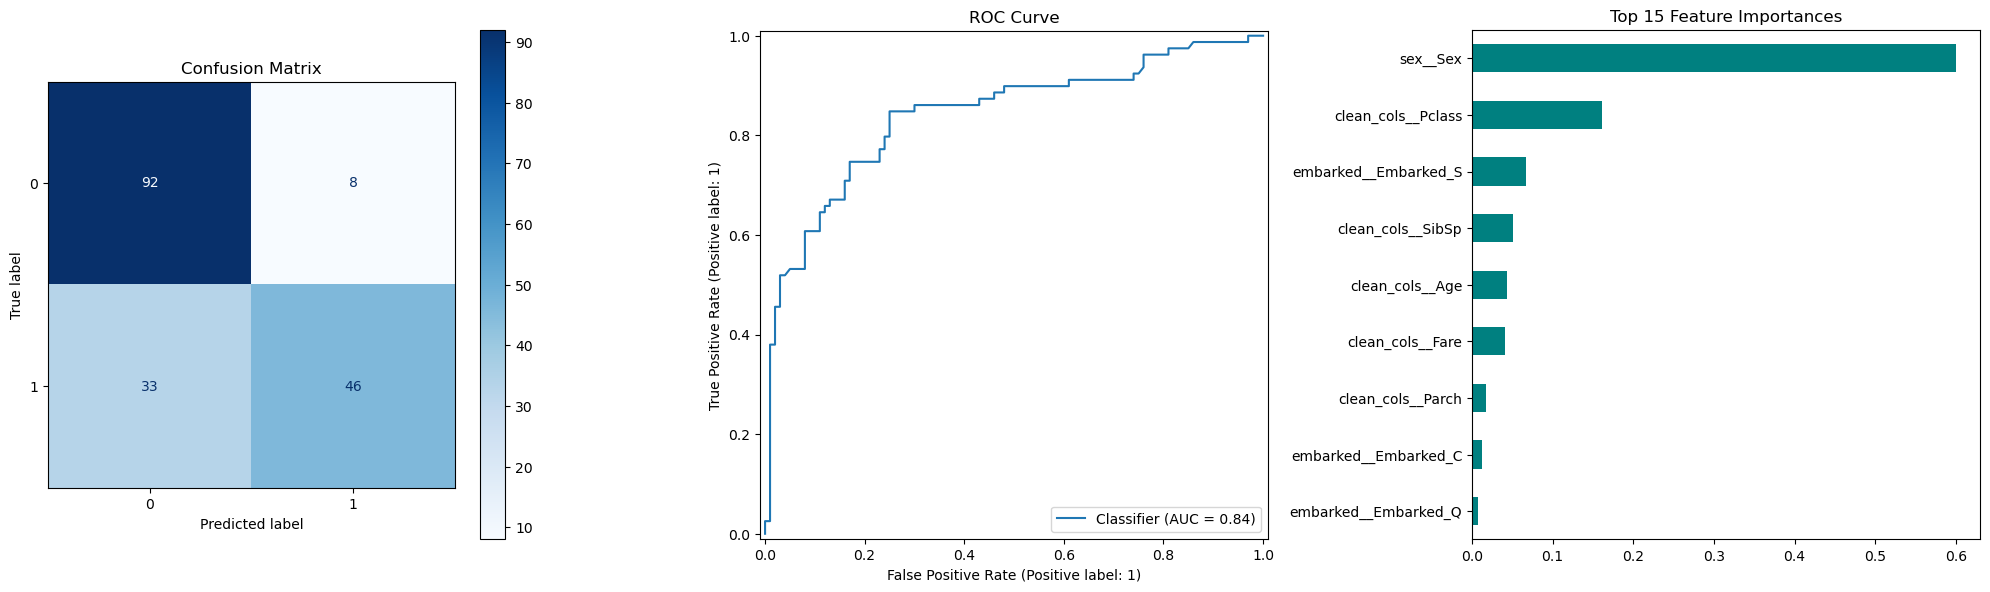

In [72]:
xgb_model = train_and_evaluate(binned_preprocessor, X_train, X_test, y_train, y_test, X=X, y=y, param_grid=param_grid_xgb)

In [73]:
from src.preprocessing import family_size_feature

clean_features = ["Pclass", "Fare",  "SibSp", "Parch","Age", "FamilySize"]

family_size_function_transformer = family_size_feature()

familySize_preprocessor = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        ("embarked", embarked_transformer(), ["Embarked"]),
        
        # pass through columns
        ("clean_cols", "passthrough", clean_features)
    ], 
remainder="drop")

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
✅ Best Params: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), 'model__learning_rate': 0.03, 'model__max_depth': 4, 'model__min_child_weight': 3, 'model__n_estimators': 340, 'model__s

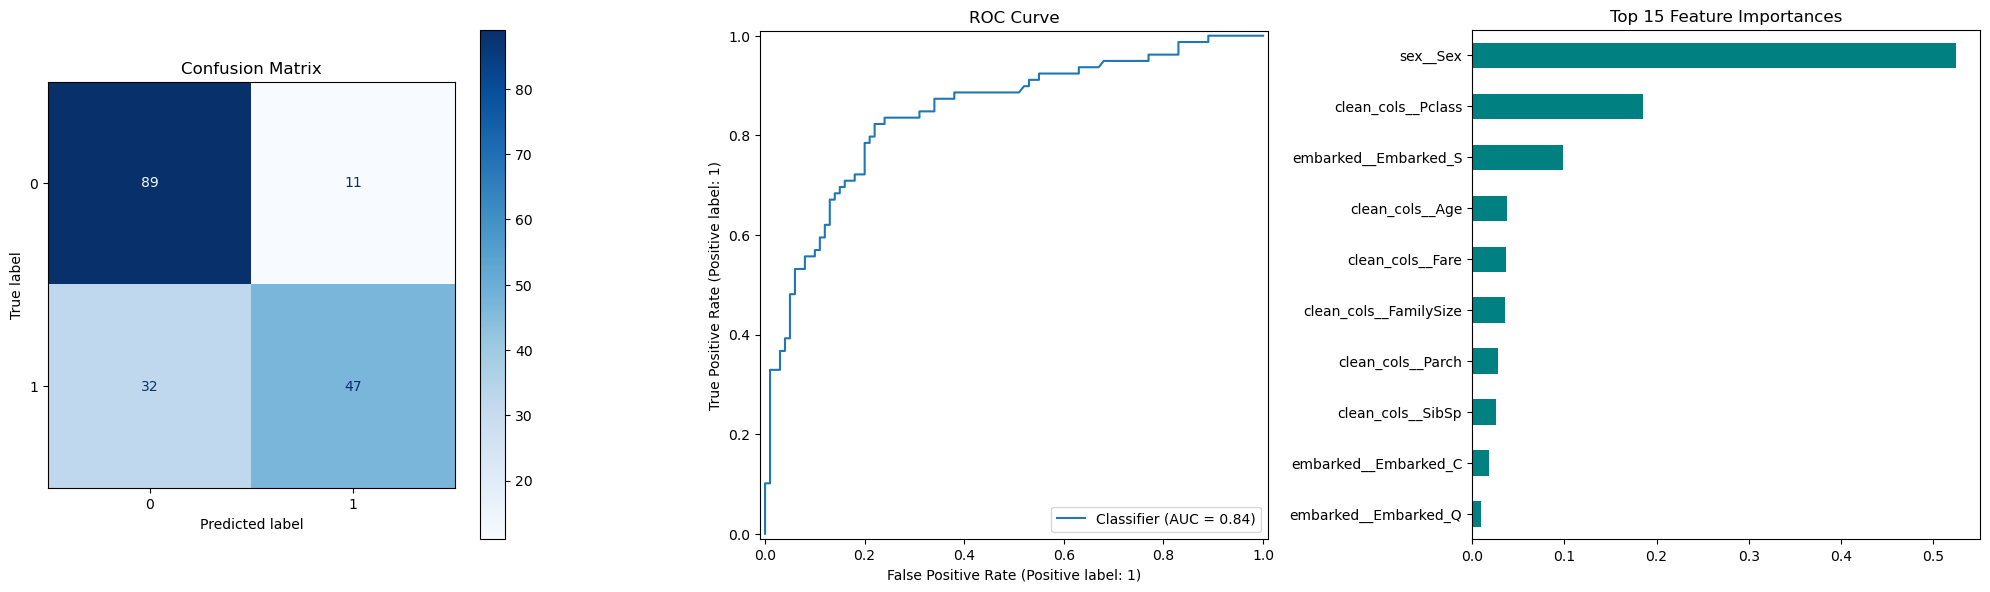

In [74]:
xgb_model = train_and_evaluate(familySize_preprocessor, X_train, X_test, y_train, y_test, X=X, y=y, feature_engineering=family_size_function_transformer, param_grid=param_grid_xgb)


In [75]:
clean_features = ["Pclass", "Fare",  "SibSp", "Parch","Age", "FamilySize"]

family_size_function_transformer = family_size_feature()

cabtik_fam_preprocessor = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        ("embarked", embarked_transformer(), ["Embarked"]),

        # new features
        ("cabin", cabin_transformer(), ["Cabin"]),
        ("ticket", ticket_transformer(), ["Ticket"]),
        # pass through columns
        ("clean_cols", "passthrough", clean_features)
    ], 
remainder="drop")

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
✅ Best Params: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), 'model__learning_rate': 0.02, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__n_estimators': 250, 'model__s

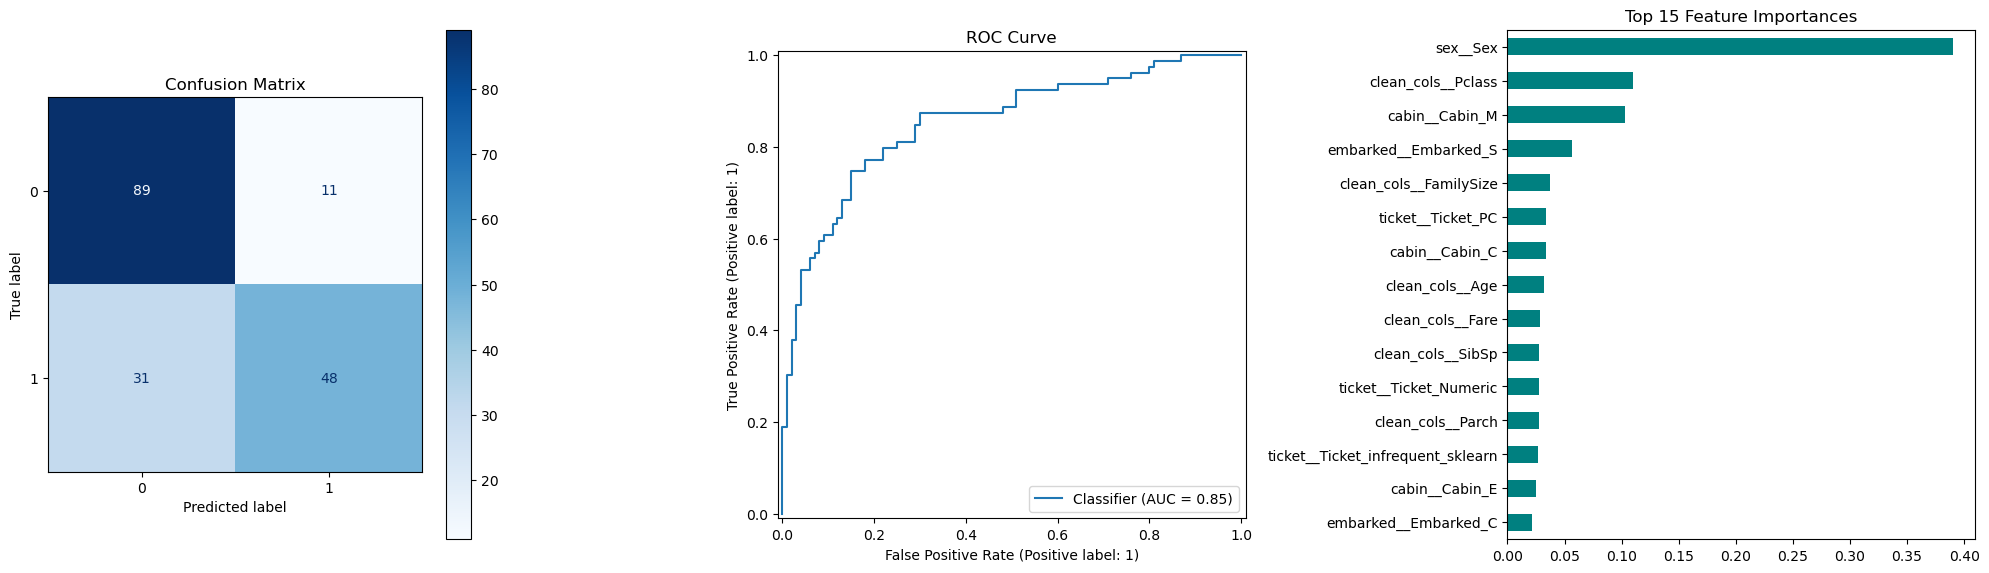

In [76]:
xgb_model = train_and_evaluate(cabtik_fam_preprocessor, X_train, X_test, y_train, y_test, X=X, y=y, feature_engineering=family_size_function_transformer, param_grid=param_grid_xgb)


In [77]:
from src.preprocessing import feat_eng_transformer

feat_eng_functionTransformer = feat_eng_transformer()

from src.preprocessing import title_transformer

clean_features = ["Pclass", "Fare",  "SibSp", "Parch","Age", "FamilySize"]

all_engineered_preprocessor = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        ("embarked", embarked_transformer(), ["Embarked"]),

        # new features
        ("cabin", cabin_transformer(), ["Cabin"]),
        ("ticket", ticket_transformer(), ["Ticket"]),
        ("title", title_transformer(), ["Title"]),
        # pass through columns
        ("clean_cols", "passthrough", clean_features)
    ], 
remainder="drop")

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
✅ Best Params: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__s

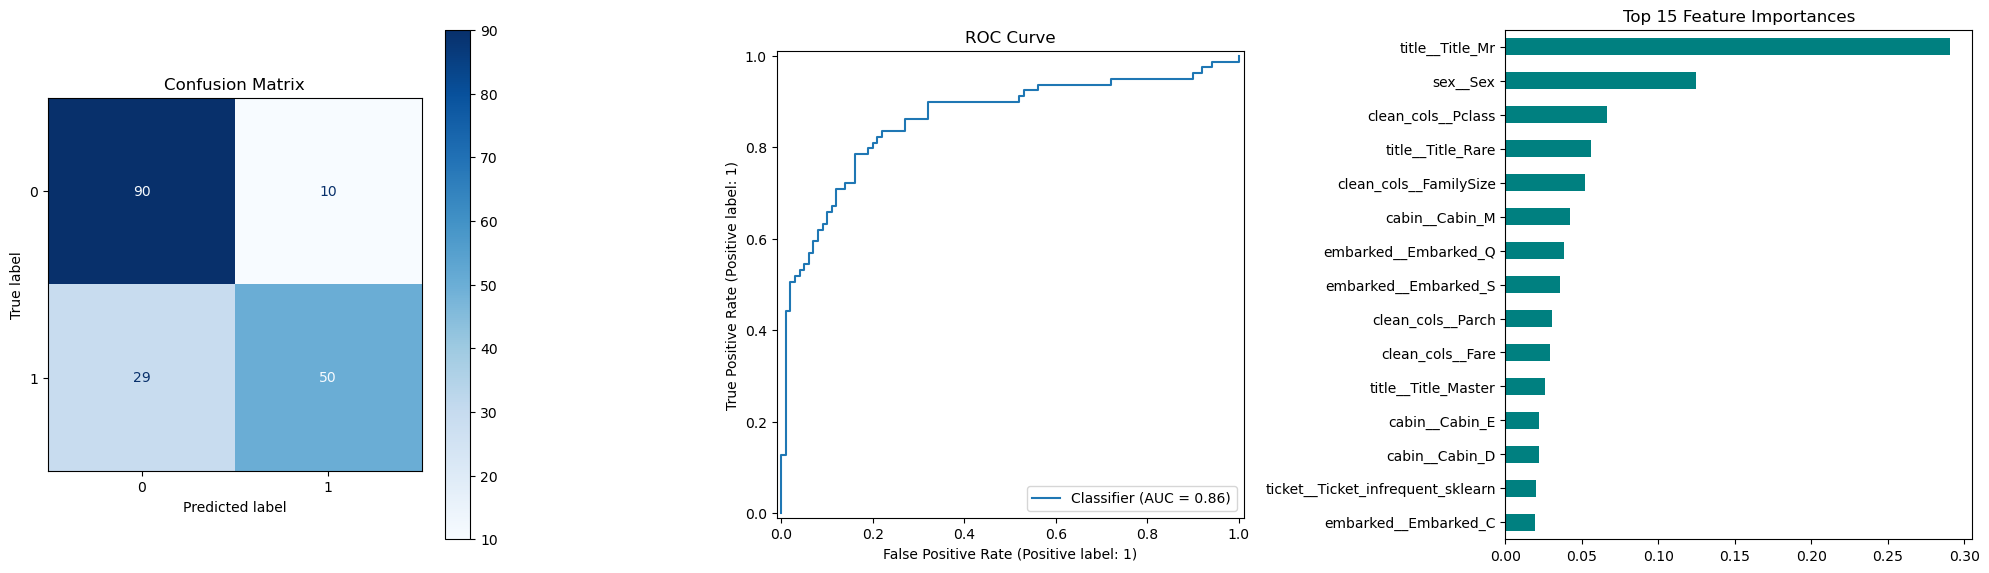

In [78]:
xgb_model = train_and_evaluate(all_engineered_preprocessor, X_train, X_test, y_train, y_test, X=X, y=y, feature_engineering=feat_eng_functionTransformer, param_grid=param_grid_xgb)


In [79]:
cv_scores_rf

{'accuracy': np.float64(0.8305567760969179),
 'precision': np.float64(0.8276249345571568),
 'recall': np.float64(0.7103580562659847),
 'f1': np.float64(0.7573859302536758)}

In [80]:
cv_scores_xgb

{'accuracy': np.float64(0.8305567760969179),
 'precision': np.float64(0.824329763803448),
 'recall': np.float64(0.7104859335038363),
 'f1': np.float64(0.7628536550989189)}

In [81]:
param_grid_xgb = [
    {
        'model': [XGBClassifier()],
        'model__n_estimators': [250, 280, 310, 340, 360, 400, 500, 600],
        'model__learning_rate': [0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.06],
        'model__max_depth': [3, 4, 5, 6, 7, 8],
        'model__subsample': [0.7, 0.8, 1],
        'model__min_child_weight': [1, 2, 3]
    }
]

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 3024 candidates, totalling 15120 fits
✅ Best Params: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 250, 'model__

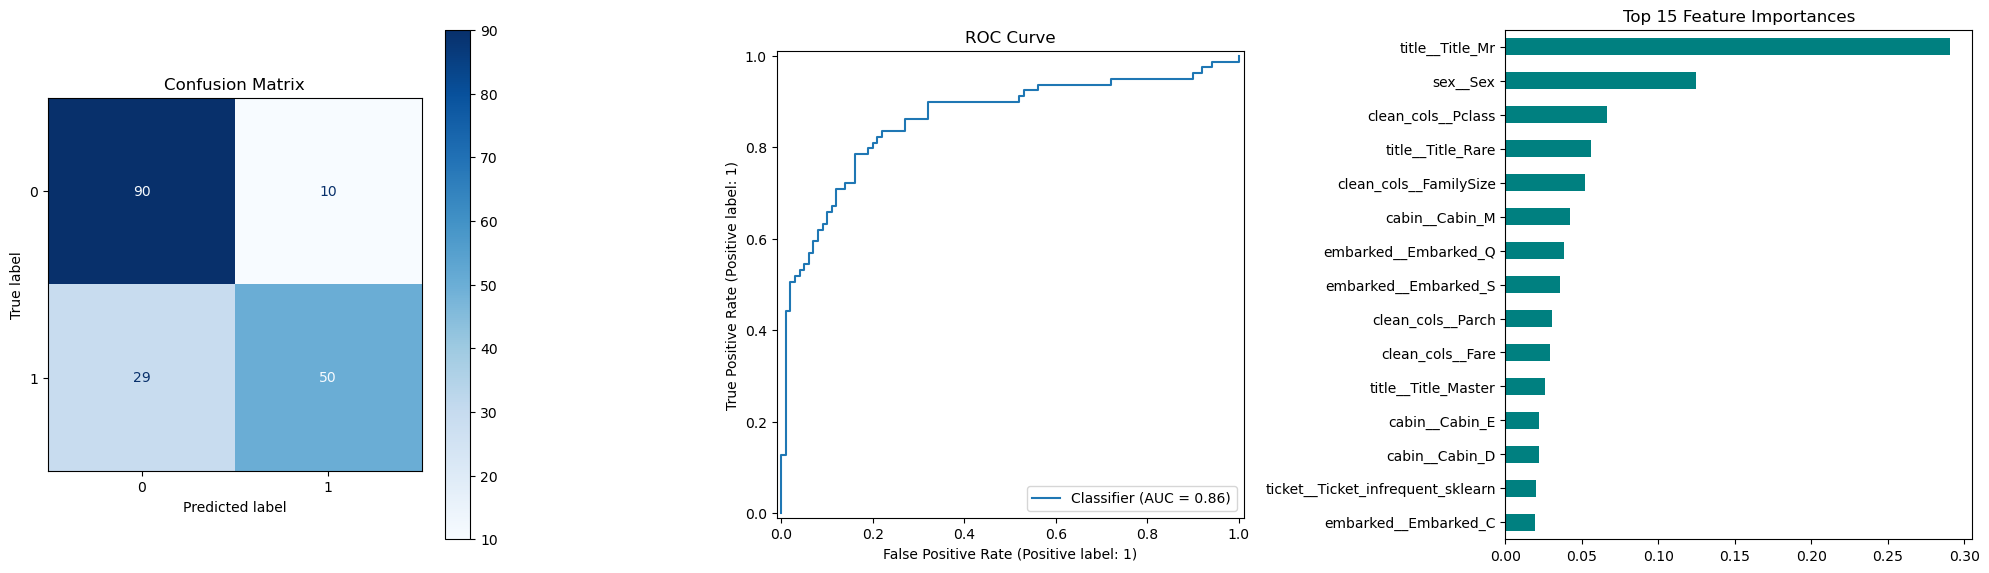

In [82]:
xgb_model = train_and_evaluate(all_engineered_preprocessor, X_train, X_test, y_train, y_test, X=X, y=y, feature_engineering=feat_eng_functionTransformer, param_grid=param_grid_xgb)


In [83]:
best_xgb_model = Pipeline(steps=[('feat_eng',feat_eng_functionTransformer),
                                 ('preprocessor', all_engineered_preprocessor),
                                 ('model', XGBClassifier(n_estimators=250,
                                                        learning_rate=0.01,
                                                        max_depth=3,
                                                        min_child_weight=1,
                                                        subsample=0.8))])

best_xgb_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feat_eng', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function eng...t 0x17f29c2c0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments 

In [84]:
best_xgb_model.score(X_test,y_test)

0.7821229050279329

In [85]:
cross_val_score(best_xgb_model, X, y)

array([0.82681564, 0.82022472, 0.83146067, 0.81460674, 0.84831461])

In [86]:
import pickle

# save our model
pickle.dump(best_xgb_model, open("models/titanic_xgboost_model_basic.pkl", "wb"))

In [87]:
loaded_pickle_model = pickle.load(open("models/titanic_xgboost_model_basic.pkl", "rb"))

In [88]:
loaded_pickle_model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1])

In [89]:
df_test = pd.read_csv("data/titanic_test_no_labels.csv")

In [90]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [91]:
test_predictions = loaded_pickle_model.predict(df_test)

In [92]:
# 1. Create a DataFrame with the two required columns
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"], 
    "Survived": test_predictions           
})

# 2. Save it to a CSV file (index=False)
# submission.to_csv("titanic_submission.csv", index=False)

print(submission.head(20))

    PassengerId  Survived
0           892         0
1           893         0
2           894         0
3           895         0
4           896         0
5           897         0
6           898         1
7           899         0
8           900         1
9           901         0
10          902         0
11          903         0
12          904         1
13          905         0
14          906         1
15          907         1
16          908         0
17          909         0
18          910         0
19          911         1


In [93]:
from src.preprocessing import create_family_survival_feature

In [94]:
X_train_full, X_test_full = create_family_survival_feature(df, df_test)

In [95]:
X_train_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,dataset,Family_Survival,FamilySize,Surname
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,0.5,2,Braund
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,1.0,2,Cumings
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,-1.0,1,Heikkinen
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,1.0,2,Futrelle
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,-1.0,1,Allen


In [96]:
X_test_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,dataset,Family_Survival,FamilySize,Surname
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,test,-1.0,1,Kelly
892,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,test,0.5,2,Wilkes
893,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,test,-1.0,1,Myles
894,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,test,-1.0,1,Wirz
895,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,test,1.0,3,Hirvonen


In [97]:
np.random.seed(12)

X_full = X_train_full.drop("Survived", axis=1)
y_full = X_train_full["Survived"]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_full, y_full, test_size=0.2)

In [149]:
from src.preprocessing import feat_eng_transformer

feat_eng_functionTransformer = feat_eng_transformer()

from src.preprocessing import title_transformer

clean_features = ["Pclass", "Fare", "Age", "FamilySize", "Family_Survival"]

all_engineered_preprocessor = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        # ("embarked", embarked_transformer(), ["Embarked"]),

        # new features
        ("cabin", cabin_transformer(), ["Cabin"]),
        ("title", title_transformer(), ["Title"]),
        # pass through columns
        ("clean_cols", "passthrough", clean_features)
    ], 
remainder="drop")

In [150]:
param_grid_xgb = [
    {
        'model': [XGBClassifier()],
        'model__n_estimators': [800, 1000, 1200],
        'model__learning_rate': [0.005, 0.007],
        'model__max_depth': [3, 4],
        'model__subsample': [0.5],
        'model__colsample_bytree': [0.5],
        'model__gamma': [0.1, 0.2],
        'model__min_child_weight': [4, 5],
        'model__reg_alpha' : [1],
        'model__reg_lambda' : [2]
    }
]

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Best Params: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), 'model__colsample_bytree': 0.5, 'model__gamma': 0.1, 'model__learning_rate': 0.005, 'model__max_depth': 4, 'model__min_chil

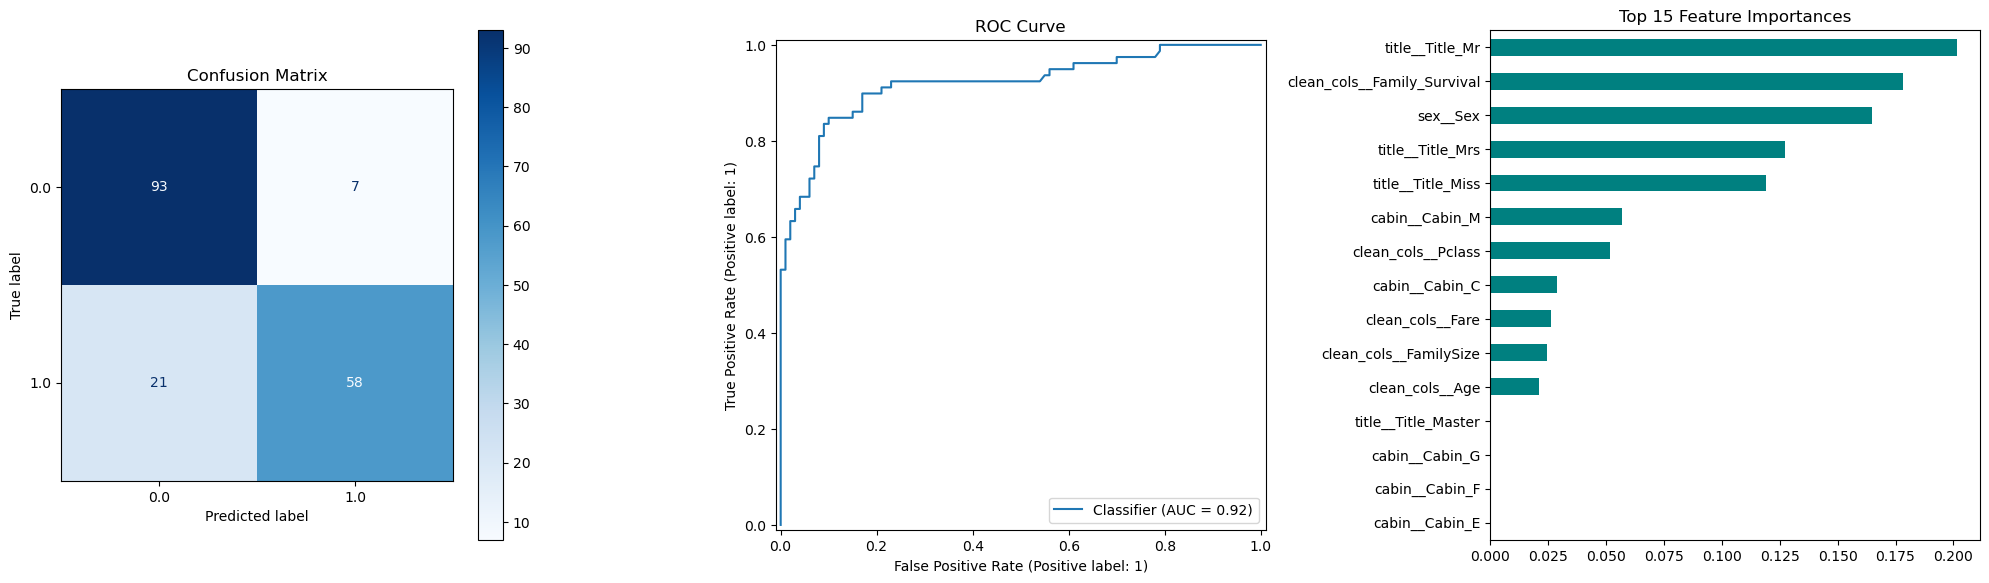

In [151]:
xgb_model = train_and_evaluate(all_engineered_preprocessor, X_train_new, X_test_new, y_train_new, y_test_new, X=X_full, y=y_full, feature_engineering=feat_eng_functionTransformer, param_grid=param_grid_xgb)


In [199]:
best_xgb_model_family_survival = Pipeline(steps=[('feat_eng',feat_eng_functionTransformer),
                                 ('preprocessor', all_engineered_preprocessor),
                                 ('model', XGBClassifier(n_estimators=800,
    learning_rate=0.005,      # slow learning
    max_depth=4,              # Force it to be shallow (Cannot memorize complex rules)
    min_child_weight=4,       # Requires 4+ people to make a rule (Stops single-family rules)

                                                         
    reg_alpha=1,              # High L1 regularization (Default is 0)
    reg_lambda=2,             # High L2 regularization (Default is 1)
    

    subsample=0.5,            # Only look at 50% of rows per tree
    colsample_bytree=0.5, # Only look at 50% of columns per tree
    
    gamma=0.1
    ))])

best_xgb_model_family_survival.fit(X_train_new, y_train_new)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feat_eng', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function eng...t 0x17f29c2c0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments 

In [200]:
best_xgb_model_family_survival.score(X_train_new, y_train_new)

0.8848314606741573

In [201]:
best_xgb_model_family_survival.score(X_test_new, y_test_new)

0.8435754189944135

In [202]:
cross_validated_scores(best_xgb_model_family_survival, X_train_full, y_full)

{'accuracy': np.float64(0.8675601029439457),
 'precision': np.float64(0.8838488766076538),
 'recall': np.float64(0.757161125319693),
 'f1': np.float64(0.8134482826845266)}

In [203]:
y_preds = best_xgb_model_family_survival.predict(X_test_new)

errors = X_test_new.copy()
errors['True_Label'] = y_test_new
errors['Predicted'] = y_preds

# Filter for mistakes
mistakes = errors[errors['True_Label'] != errors['Predicted']]

# Look at the top 10 mistakes
mistakes.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,dataset,Family_Survival,FamilySize,Surname,True_Label,Predicted
235,236,3,"Harknett, Miss. Alice Phoebe",female,NaN,0,0,W./C. 6609,7.5500,NaN,S,train,-1.0,1,Harknett,0.0,1
848,849,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S,train,1.0,2,Harper,0.0,1
547,548,2,"Padro y Manent, Mr. Julian",male,NaN,0,0,SC/PARIS 2146,13.8625,NaN,C,train,-1.0,1,Padro y Manent,1.0,0
298,299,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,C106,S,train,-1.0,1,Saalfeld,1.0,0
267,268,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S,train,0.5,2,Persson,1.0,0


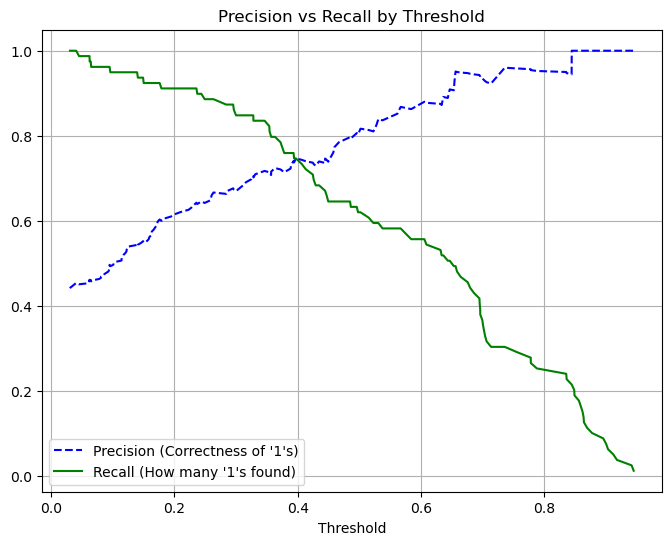

In [204]:
# Get probabilities for the positive class (Survived)
y_scores = best_model.predict_proba(X_test_new)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_new, y_scores)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], "b--", label="Precision (Correctness of '1's)")
plt.plot(thresholds, recall[:-1], "g-", label="Recall (How many '1's found)")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.grid()
plt.title("Precision vs Recall by Threshold")
plt.show()

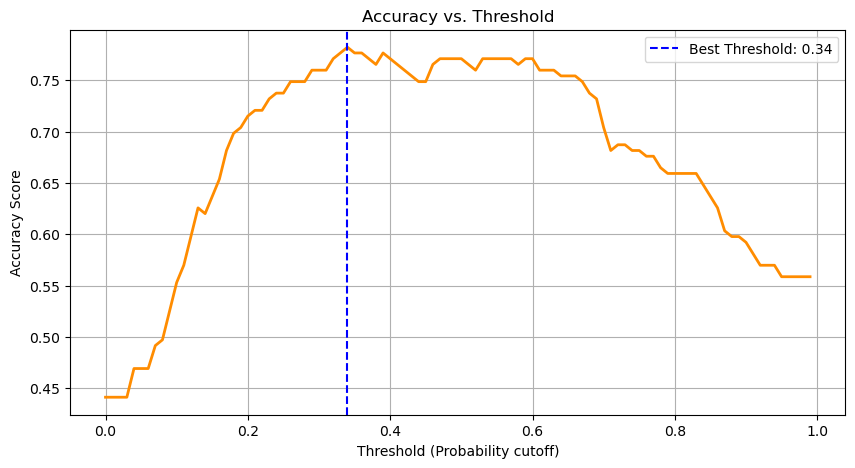

🏆 The Peak Accuracy is 0.7821 at threshold 0.34


In [205]:
# 2. Calculate accuracy for every possible threshold
thresholds = np.arange(0.0, 1.0, 0.01)
accuracies = []

for t in thresholds:
    preds = (y_scores >= t).astype(int)
    accuracies.append(accuracy_score(y_test_new, preds))

# 3. Plot the Hill
plt.figure(figsize=(10, 5))
plt.plot(thresholds, accuracies, color='darkorange', lw=2)
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold (Probability cutoff)')
plt.ylabel('Accuracy Score')
plt.grid(True)

# Find the peak
best_acc = max(accuracies)
best_t = thresholds[accuracies.index(best_acc)]

plt.axvline(best_t, color='blue', linestyle='--', label=f'Best Threshold: {best_t:.2f}')
plt.legend()
plt.show()

print(f"🏆 The Peak Accuracy is {best_acc:.4f} at threshold {best_t:.2f}")

In [214]:
import pickle

# save our model

pickle.dump(best_xgb_model_family_survival, open("./models/titanic_xgboost_model.pkl", "wb"))

loaded_pickle_model = pickle.load(open("./models/titanic_xgboost_model.pkl", "rb"))

y_probs = loaded_pickle_model.predict_proba(X_test_full)[:,1]

test_predictions = (y_probs >= 0.50).astype(int)

In [207]:

# 1. Create a DataFrame with the two required columns
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"], 
    "Survived": test_predictions           
})

# 2. Save it to a CSV file (index=False)
submission.to_csv("./submissions/titanic_submission_xgboost.csv", index=False)

print(submission.head(20))

    PassengerId  Survived
0           892         0
1           893         0
2           894         0
3           895         0
4           896         0
5           897         0
6           898         1
7           899         0
8           900         1
9           901         0
10          902         0
11          903         0
12          904         1
13          905         0
14          906         1
15          907         1
16          908         0
17          909         0
18          910         0
19          911         1


In [208]:
param_grid_rf = [
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [ 400, 500, 800, 1000, 1200],
        'model__max_depth': [2, 3,4],
        'model__min_samples_split': [ 2,3,4, 5, 10],
        'model__min_samples_leaf': [3, 4, 6],
        'model__bootstrap': [True]
    }
]

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 225 candidates, totalling 1125 fits
✅ Best Params: {'model': RandomForestClassifier(), 'model__bootstrap': True, 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4, 'model__n_estimators': 1200}

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87       100
         1.0       0.89      0.72      0.80        79

    accuracy                           0.84       179
   macro avg       0.85      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179


CROSS-VALIDATED SCORES ON X AND Y
{'accuracy': np.float64(0.8540957880861214), 'precision': np.float64(0.8953216140080155), 'recall': np.float64(0.7104859335038364), 'f1': np.float64(0.7866941160936378)}


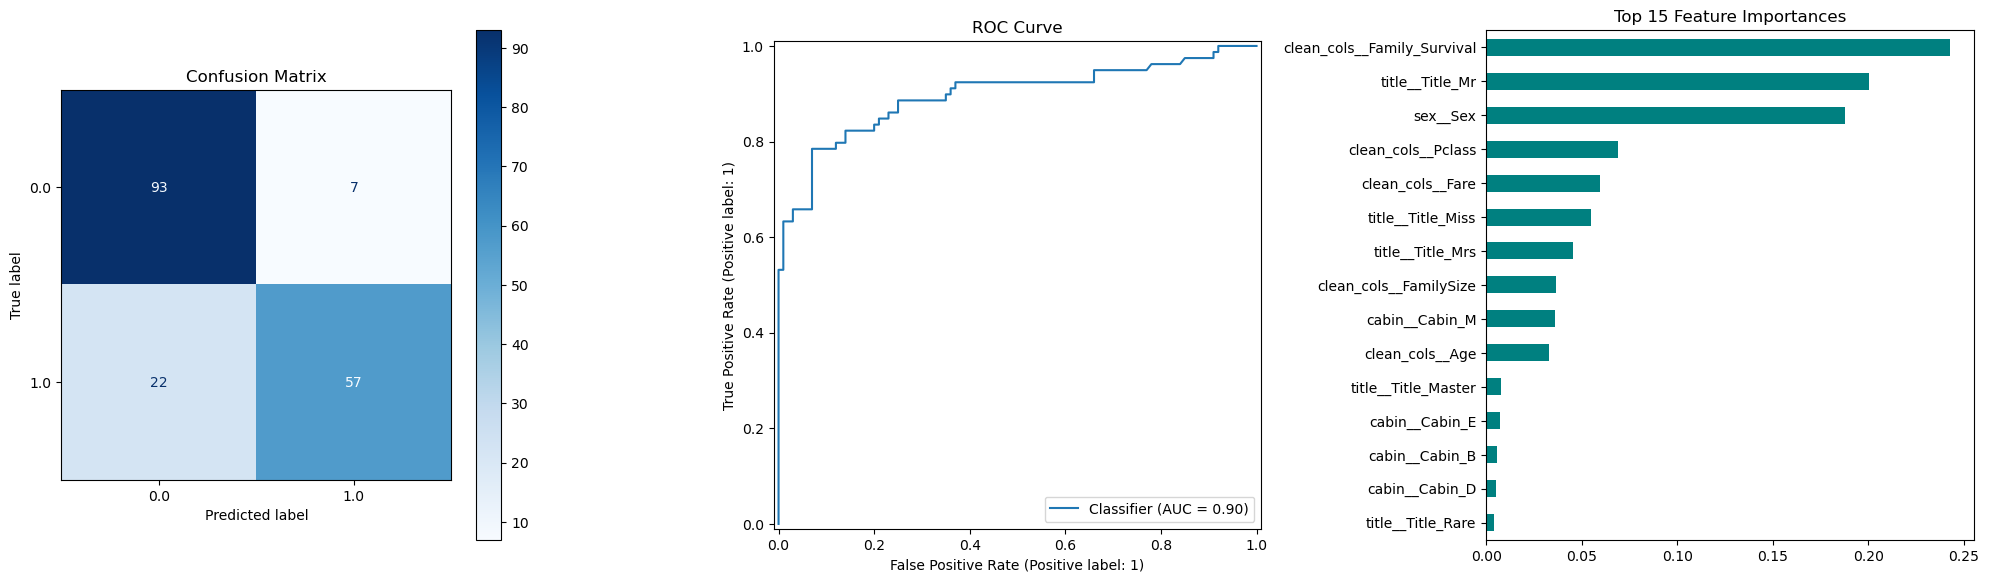

In [209]:
rf_model = train_and_evaluate(all_engineered_preprocessor, X_train_new, X_test_new, y_train_new, y_test_new, X=X_full, y=y_full, feature_engineering=feat_eng_functionTransformer, param_grid=param_grid_rf)


In [218]:
best_rf_model_family_survival = Pipeline(steps=[('feat_eng',feat_eng_functionTransformer),
                                 ('preprocessor', all_engineered_preprocessor),
                                 ('model', RandomForestClassifier(
                                     n_estimators=1000,
                                     max_depth=4,
                                     min_samples_split=4,
                                     min_samples_leaf=4
                                 ))])

best_rf_model_family_survival.fit(X_train_new, y_train_new)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feat_eng', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function eng...t 0x17f29c2c0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments 

In [219]:
best_rf_model_family_survival.score(X_train_new, y_train_new)

0.8820224719101124

In [220]:
best_rf_model_family_survival.score(X_test_new, y_test_new)

0.8435754189944135

In [221]:
cross_validated_scores(best_rf_model_family_survival, X_full, y_full)

{'accuracy': np.float64(0.8585838930387295),
 'precision': np.float64(0.888964718902948),
 'recall': np.float64(0.7134271099744246),
 'f1': np.float64(0.7890216236082155)}

In [213]:

clean_features = []

from src.preprocessing import age_binning_transformer

from src.preprocessing import fare_bin_transformer

from src.preprocessing import family_size_transformer

cat_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

logreg_engineered_preprocessor = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        # ("embarked", embarked_transformer(), ["Embarked"]),
        ("cabin", cabin_transformer(), ["Cabin"]),
        ("title", title_transformer(), ["Title"]),

        ("age", age_binning_transformer(), ["Age"]),
        ("fams_size", family_size_transformer(), ["FamilySize"]),
        ("fare", fare_bin_transformer(), ["Fare"]),
        ("cat", cat_transformer, ["Pclass","Family_Survival"]),
        # pass through columns
        ("clean_cols", "passthrough", clean_features)
    ], 
remainder="drop")

In [180]:
param_grid_lr = [
    {
        'model': [LogisticRegression()],
        'model__C': [ 0.002, 0.1, 1],
        'model__solver': ["lbfgs", "liblinear"]
    }
]

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Params: {'model': LogisticRegression(), 'model__C': 0.1, 'model__solver': 'liblinear'}

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       100
         1.0       0.88      0.77      0.82        79

    accuracy                           0.85       179
   macro avg       0.86      0.85      0.85       179
weighted avg       0.86      0.85      0.85       179


CROSS-VALIDATED SCORES ON X AND Y
{'accuracy': np.float64(0.8687025296591552), 'precision': np.float64(0.871998972831301), 'recall': np.float64(0.7748081841432225), 'f1': np.float64(0.818995984108791)}
⚠️ Could not plot feature importance: 'LogisticRegression' object has no attribute 'feature_importances_'


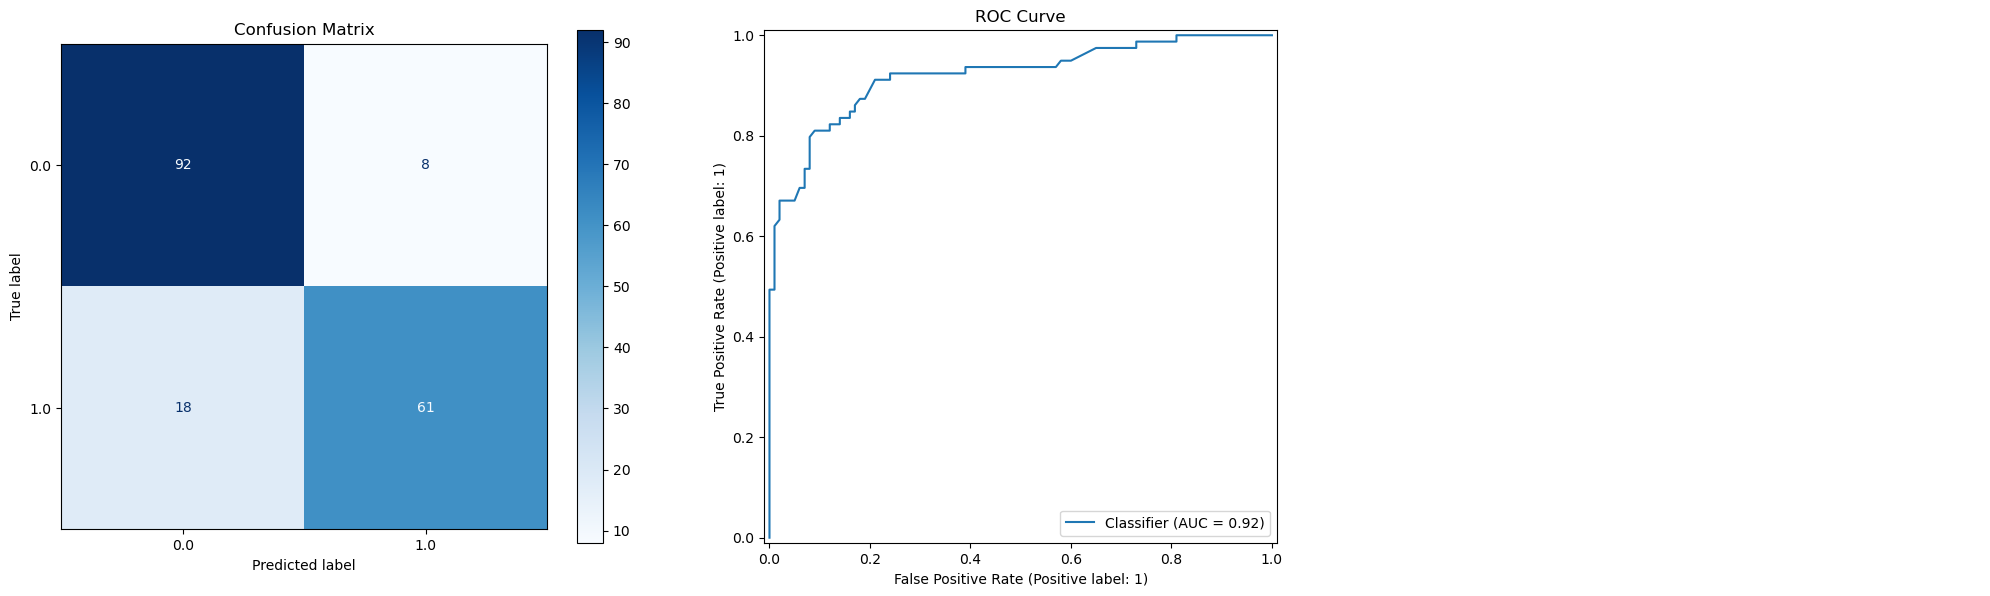

In [181]:
lr_model = train_and_evaluate(logreg_engineered_preprocessor, X_train_new, X_test_new, y_train_new, y_test_new, X=X_full, y=y_full, feature_engineering=feat_eng_functionTransformer, param_grid=param_grid_lr)


In [223]:
best_lr_model_family_survival = Pipeline(steps=[('feat_eng',feat_eng_functionTransformer),
                                 ('preprocessor', logreg_engineered_preprocessor),
                                 ('model', LogisticRegression(
                                     C=0.1,
                                     solver="liblinear"
                                 ))])

best_lr_model_family_survival.fit(X_train_new, y_train_new)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feat_eng', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function eng...t 0x17f29c2c0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments 

In [224]:
best_lr_model_family_survival.score(X_train_new, y_train_new)

0.8876404494382022

In [225]:
best_lr_model_family_survival.score(X_test_new, y_test_new)

0.8547486033519553

In [226]:
cross_validated_scores(best_lr_model_family_survival, X_full, y_full)


{'accuracy': np.float64(0.8687025296591552),
 'precision': np.float64(0.871998972831301),
 'recall': np.float64(0.7748081841432225),
 'f1': np.float64(0.818995984108791)}

In [185]:
# 1. Get the model and preprocessor steps
model = best_lr_model_family_survival.named_steps['model']
preprocessor = best_lr_model_family_survival.named_steps['preprocessor']

# 2. Get names and coefficients
feature_names = preprocessor.get_feature_names_out()
coefficients = model.coef_[0]

# 3. Combine into a clean DataFrame
df_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(df_coef)

                        Feature  Coefficient
39     cat__Family_Survival_1.0     1.218883
13             title__Title_Mrs     0.505388
11            title__Title_Miss     0.473400
10          title__Title_Master     0.397064
33                cat__Pclass_1     0.360937
5                cabin__Cabin_E     0.301836
27   fams_size__FamilySize_Solo     0.264699
4                cabin__Cabin_D     0.247116
36    cat__Family_Survival_-1.0     0.240776
31               fare__Fare_3.0     0.180903
2                cabin__Cabin_B     0.169059
23         age__Age_Small_child     0.154786
26  fams_size__FamilySize_Small     0.153591
20           age__Age_Old adult     0.139713
15          age__Age_Adolescent     0.137959
17              age__Age_Infant     0.125039
32               fare__Fare_4.0     0.112554
30               fare__Fare_2.0     0.071907
18         age__Age_Large_child     0.065177
16               age__Age_Adult     0.055350
38     cat__Family_Survival_0.5     0.053704
34        

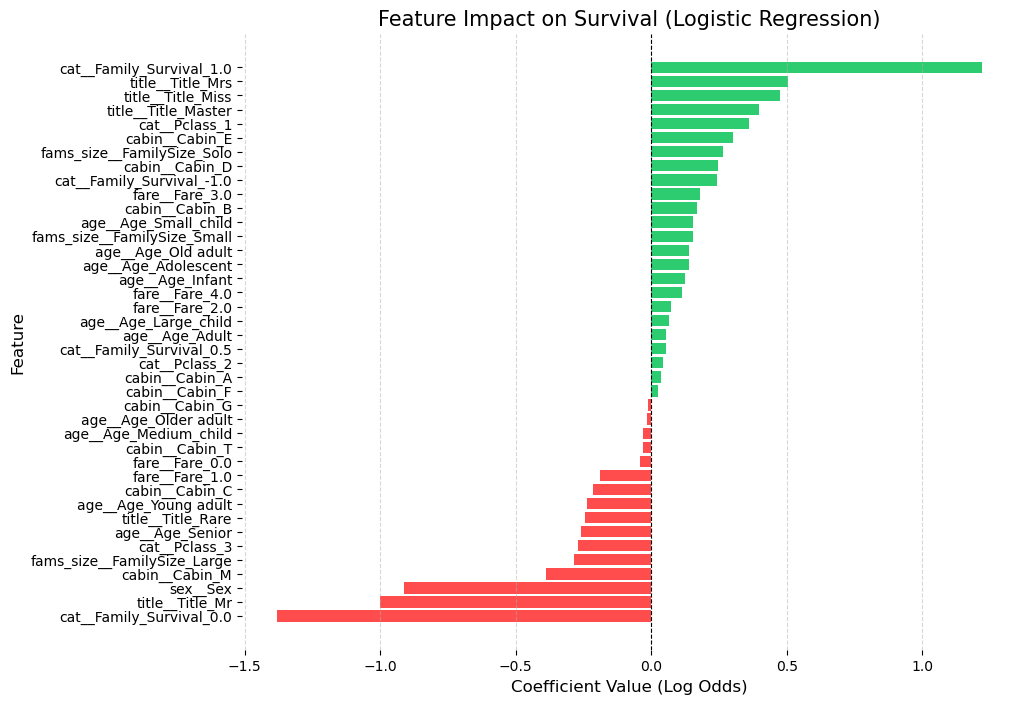

In [186]:
# 1. Sort the Data
# We sort by the actual value so the graph flows from Negative -> Positive
plot_df = df_coef.sort_values(by='Coefficient', ascending=True)

# Optional: Slice to top/bottom 20 if you have too many features
# plot_df = pd.concat([plot_df.head(10), plot_df.tail(10)])

# 2. Setup the Colors
# Red for Negative (Died), Green for Positive (Survived)
colors = ['#ff4d4d' if c < 0 else '#2ecc71' for c in plot_df['Coefficient']]

# 3. Create the Plot
plt.figure(figsize=(10, 8)) # Make it big enough to read

# The Bar Chart
plt.barh(plot_df['Feature'], plot_df['Coefficient'], color=colors)

# 4. Make it "Nice"
plt.axvline(0, color='black', linewidth=0.8, linestyle='--') # The Zero Line
plt.title('Feature Impact on Survival (Logistic Regression)', fontsize=15)
plt.xlabel('Coefficient Value (Log Odds)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5) # Faint grid for readability

# Remove the ugly box border around the graph
sns.despine(left=True, bottom=True)

plt.show()

In [190]:
# Create the Ensemble

# 3. Combine them into the Voter
# Note: We pass the PIPELINES, not the models directly
voting_clf = VotingClassifier(
    estimators=[
        ('lr_branch', best_lr_model_family_survival),
        ('xgb_branch',best_xgb_model_family_survival),
        ('rf_branch', best_rf_model_family_survival)
    ],
    voting='hard'
)

voting_clf.fit(X_train_new, y_train_new)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr_branch', ...), ('xgb_branch', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function eng...t 0x17f29c2c0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True


In [191]:
voting_clf.score(X_train_new, y_train_new)

0.8848314606741573

In [192]:
voting_clf.score(X_test_new, y_test_new)

0.8435754189944135

In [193]:
cross_validated_scores(voting_clf, X_full, y_full)


{'accuracy': np.float64(0.8664427845081916),
 'precision': np.float64(0.8889477257681081),
 'recall': np.float64(0.7454816709292412),
 'f1': np.float64(0.8082024769152701)}

In [195]:
y_preds = voting_clf.predict(X_test_new)

# y_proba = voting_clf.predict_proba(X_test_new)[:,1]

Text(0.5, 1.0, 'ROC Curve')

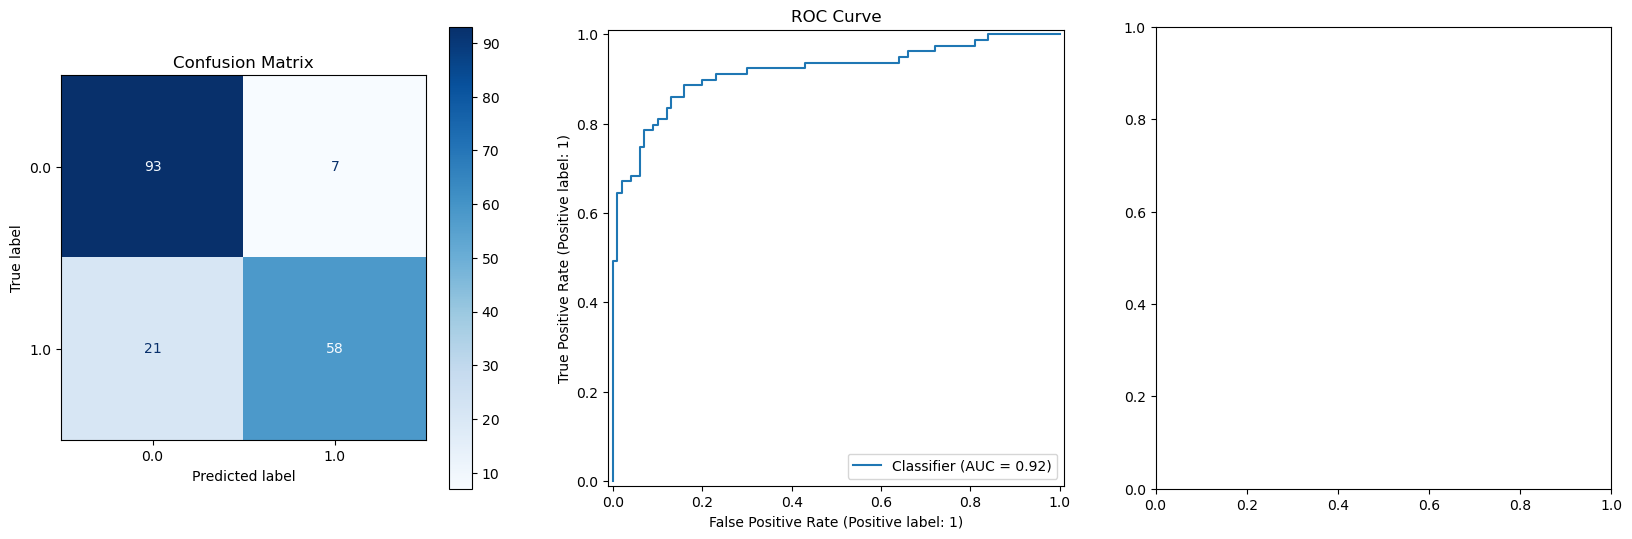

In [196]:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    ConfusionMatrixDisplay.from_predictions(y_test_new, y_preds, cmap='Blues', ax=axes[0])
    axes[0].set_title("Confusion Matrix")

    RocCurveDisplay.from_predictions(y_test_new, y_proba, ax=axes[1])
    axes[1].set_title("ROC Curve")

In [198]:

# save our model

pickle.dump(voting_clf, open("./models/titanic_voting_model.pkl", "wb"))

loaded_pickle_model = pickle.load(open("./models/titanic_voting_model.pkl", "rb"))

test_predictions = loaded_pickle_model.predict(X_test_full)

# 1. Create a DataFrame with the two required columns
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"], 
    "Survived": test_predictions           
})

submission["Survived"] = submission["Survived"].astype(int)

# 2. Save it to a CSV file (index=False)
submission.to_csv("./submissions/titanic_submission_voting.csv", index=False)

print(submission.head(20))

    PassengerId  Survived
0           892         0
1           893         1
2           894         0
3           895         0
4           896         1
5           897         0
6           898         1
7           899         0
8           900         1
9           901         0
10          902         0
11          903         0
12          904         1
13          905         0
14          906         1
15          907         0
16          908         0
17          909         0
18          910         0
19          911         1
